In [47]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [48]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

def generate_points_distribution(data_num=2000, dist_type="circle"):
    if dist_type == 'spiral':
        theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
        radius = np.linspace(0, 0.35, data_num)  # 반지름 범위를 정의합니다.
        xx = 0.5 + radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = 0.4 + radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'box':
        xx = np.random.uniform(0.4, 0.8, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = np.random.uniform(0.2, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'curve':
        xx = np.linspace(0.15, 0.85, data_num) + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = 3.8 * xx*xx - 3.8 * xx + 1.2 + 0.03 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'circle':
        radius = 0.20
        theta = np.linspace(0, 2 * np.pi, data_num)  # 각도 범위를 정의합니다.
        xx = radius * np.cos(theta) + 0.5 + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = radius * np.sin(theta) + 0.55 + 0.02 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'lemniscate':
        xx = []
        yy = []
        while len(xx) < data_num:
            x = np.random.uniform(0, 0.5)
            y = np.random.uniform(0, 0.5)
            
            r = (x**2 + y**2)**0.5
            theta = np.arctan2(y, x)
            if r**2 <= 2 * 0.25**2 * np.cos(2 * theta):
                x = x if np.random.uniform(0, 1) < 0.5 else -x
                y = y if np.random.uniform(0, 1) < 0.5 else -y
                xx.append(x+0.5)
                yy.append(y+0.5)

    data = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
    np.random.shuffle(data)
    
    return data

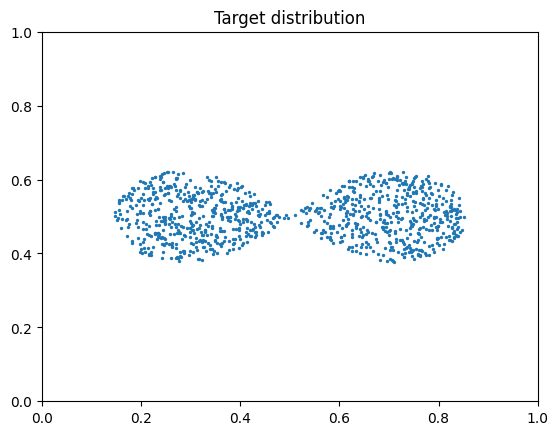

In [160]:
x = generate_points_distribution(1000, 'lemniscate')
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [152]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [161]:
noise_qubits = 6
output_qubits = 2
code_qubits = 2
assert(output_qubits <= noise_qubits-code_qubits) # 출력 큐빗은 noise qubit미만이어야 한다.
n_qubits = noise_qubits + code_qubits

n_layers = 15
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 8 n_layers = 15


In [162]:
coeff = 0.15

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[::2] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    generator_output = 2 * (2 / np.pi * torch.arcsin(torch.sqrt(generator_output))) -0.5 # (BATCH_SIZE, n_qubits) 차원
    # 곱하기 2 해서 범위를 초과하게 만들음

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [175]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 100
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 10
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.2*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [176]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

parameter shape:  torch.Size([15, 8, 3])


In [177]:
G_lr = 3e-4
D_lr = 1e-4
M_lr = 3e-4
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

In [178]:
def visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder):
    plt.figure(figsize=(10 + 4 * code_qubits, 4))  # 전체 그림의 크기 지정
    
    plt.subplot(1, 1 + code_qubits, 1)
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10,  alpha=0.2)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.grid()

    for i in range(code_qubits):
        plt.subplot(1, 1 + code_qubits, 2 + i)
        plt.title('Epoch {0} code {1}'.format(rep, i))
        plt.scatter(log_gen_outputs[:,0], log_gen_outputs[:,1], s=10, c=log_gen_codes[:, i], cmap='RdYlBu', alpha=0.2)
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.colorbar()  # 색상 막대 추가
        plt.grid()

    plt.savefig(f'result/{title}/{rep}.png', dpi=300)
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title('Epoch {0} code-axis corr'.format(rep))
    for i in range(code_qubits):
        plt.plot(recorder[f'code{i}-x'], label=f'code{i}-x', marker='o')
        plt.plot(recorder[f'code{i}-y'], label=f'code{i}-y', marker='o')

    plt.xlabel('epoch')
    plt.ylabel('correlation')
    plt.ylim(-1, 1)
    plt.title(f'code - axis corr graph (rep={rep})')
    plt.legend()
    plt.savefig(f'result/{title}/{rep}_corr.png', dpi=300)
    plt.show()
    

100%|██████████| 31/31 [00:59<00:00,  1.92s/it, G_loss=-.701, D_loss=0.692, MI=-.0057] 


epoch: 1, D_loss: 0.6923665692729335, G_loss: -0.7008220188079342, MI = -0.005701373661718061
a_loss: -43.45096516609192, b_loss: 35.918165164743044
좌표값 평균 =  0.48491067 0.501341


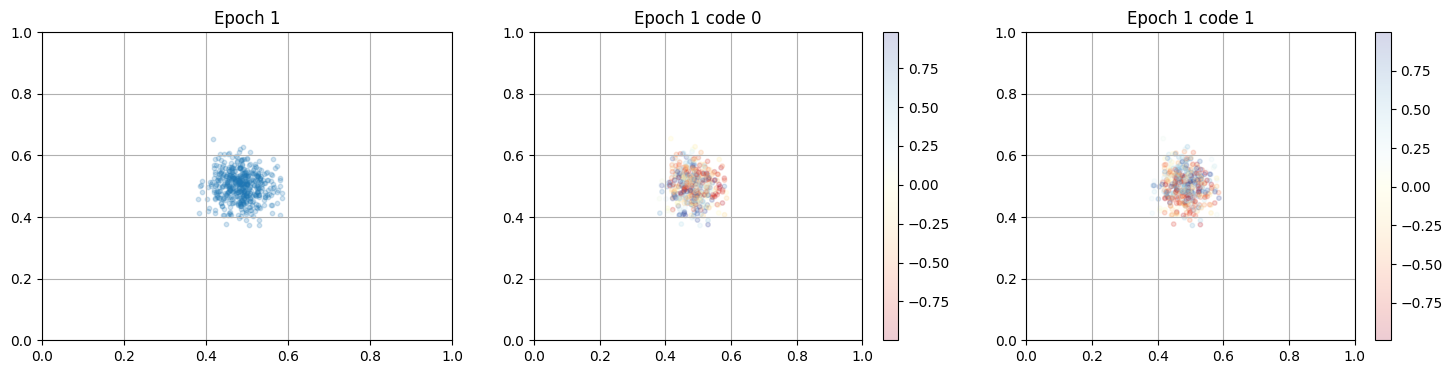

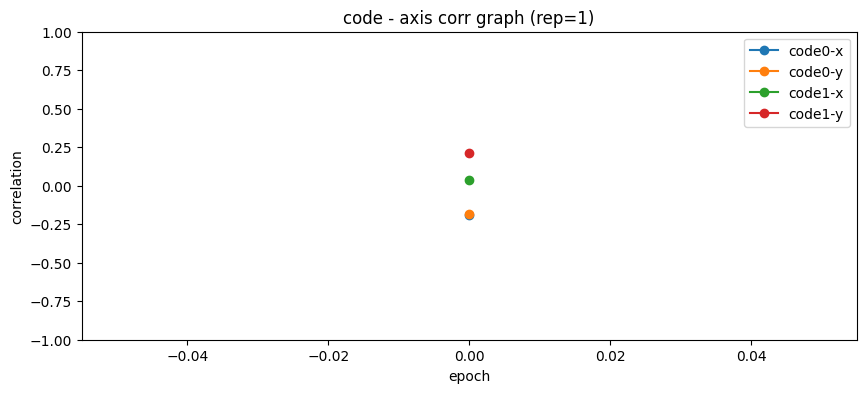

100%|██████████| 31/31 [01:00<00:00,  1.94s/it, G_loss=-.691, D_loss=0.691, MI=-.00273]


epoch: 2, D_loss: 0.6914996274055973, G_loss: -0.6912766771931802, MI = -0.0027306483637902046
a_loss: -42.85915398597717, b_loss: 35.5039053623158
좌표값 평균 =  0.4864262 0.51128614


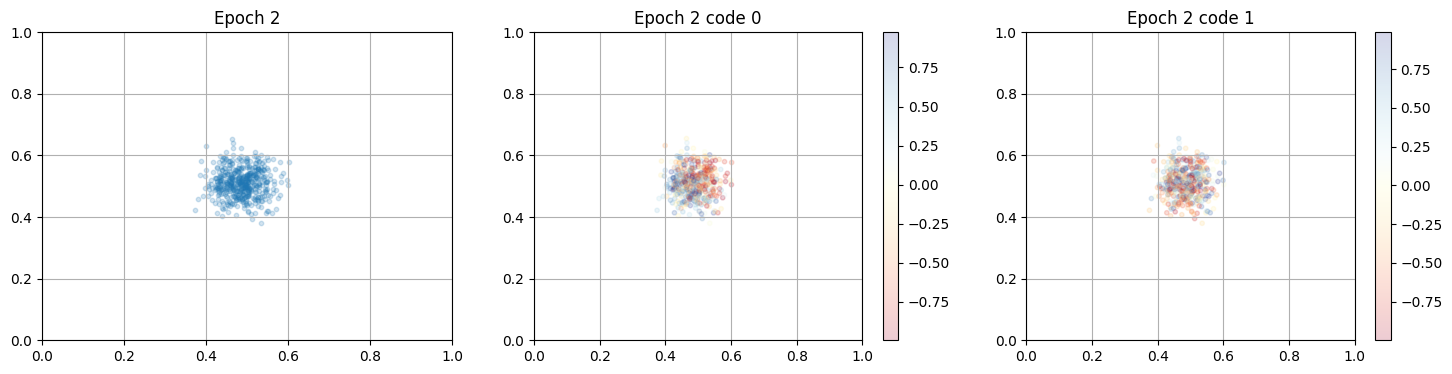

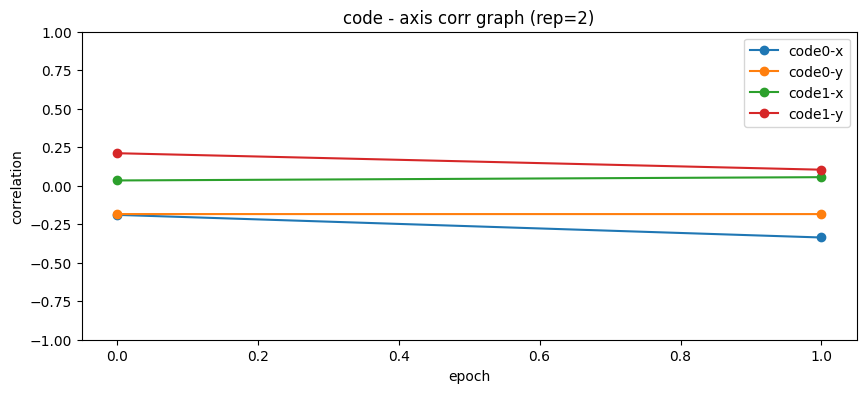

100%|██████████| 31/31 [01:00<00:00,  1.94s/it, G_loss=-.691, D_loss=0.691, MI=-.00209]


epoch: 3, D_loss: 0.6906021314282571, G_loss: -0.6911409881807142, MI = -0.0020863615697430025
a_loss: -42.850741267204285, b_loss: 33.424398963061954
좌표값 평균 =  0.48576322 0.51513463


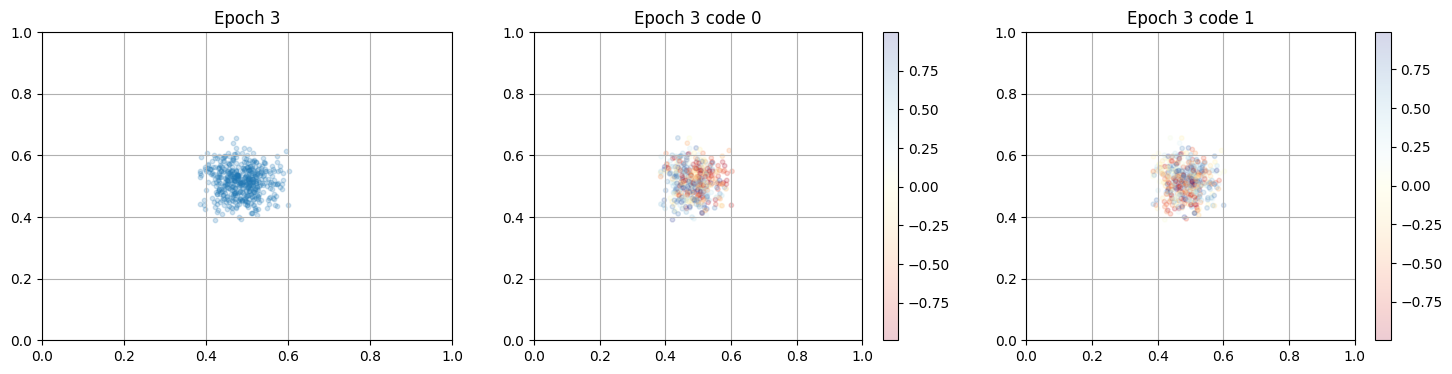

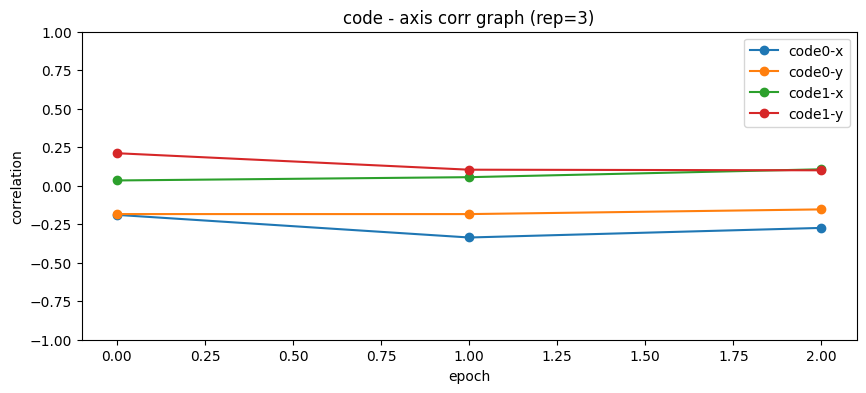

100%|██████████| 31/31 [01:00<00:00,  1.94s/it, G_loss=-.69, D_loss=0.689, MI=-.00125]


epoch: 4, D_loss: 0.6893130194756293, G_loss: -0.6904373976492113, MI = -0.001251054386938772
a_loss: -42.8071186542511, b_loss: 35.31244389284496
좌표값 평균 =  0.4965996 0.5078588


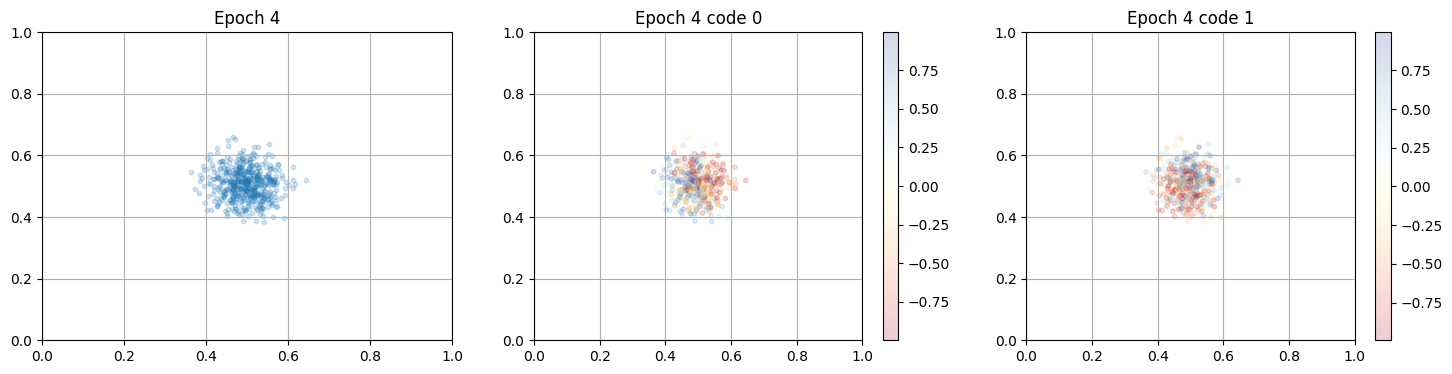

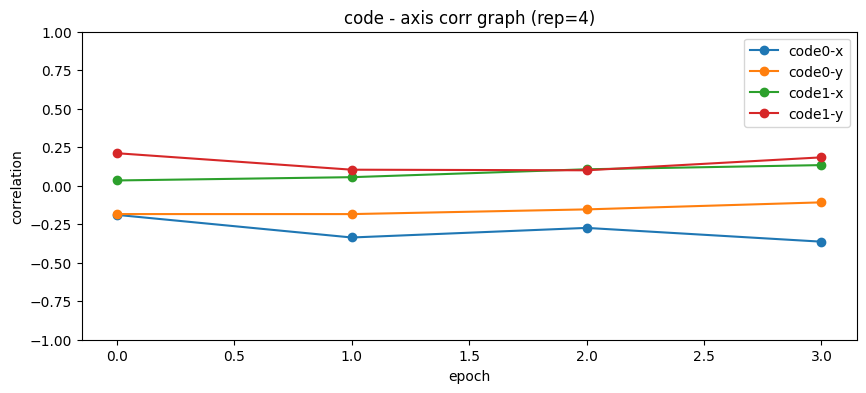

100%|██████████| 31/31 [01:00<00:00,  1.95s/it, G_loss=-.688, D_loss=0.688, MI=-.00104] 


epoch: 5, D_loss: 0.6881125665480091, G_loss: -0.6876524532994917, MI = -0.0010445367905401414
a_loss: -42.63445210456848, b_loss: 36.77695247956428
좌표값 평균 =  0.5139893 0.5061001


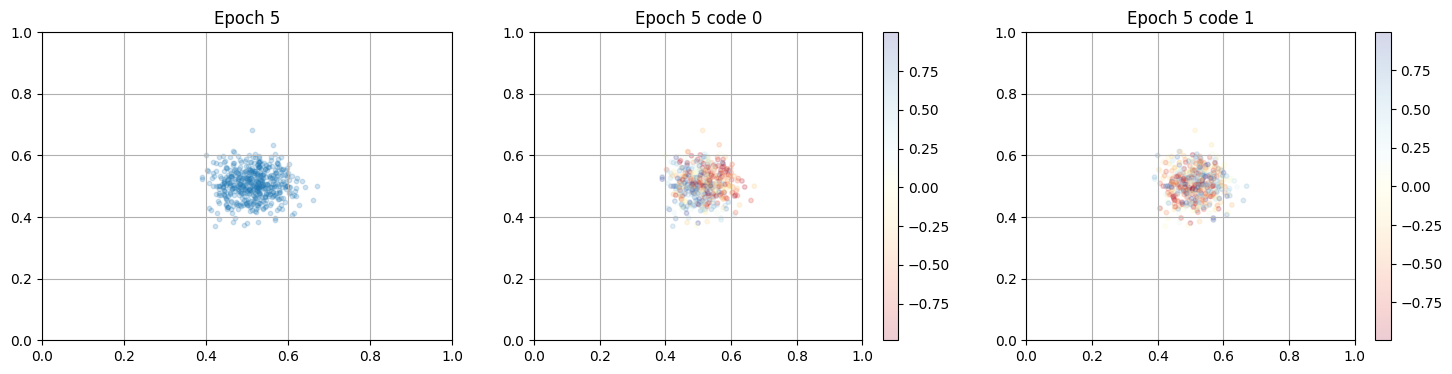

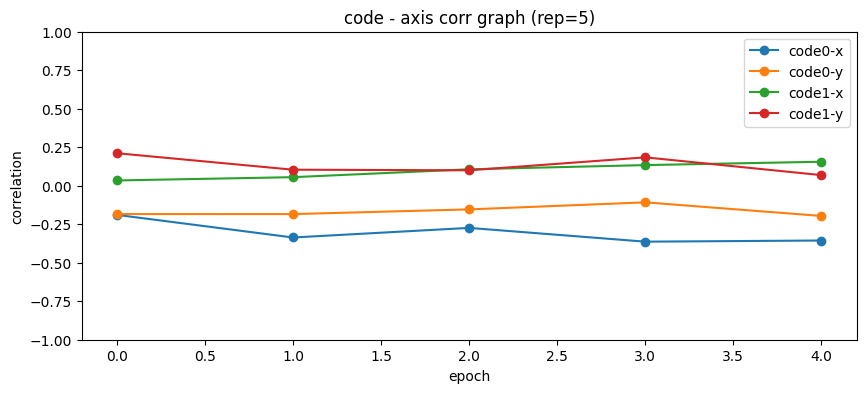

100%|██████████| 31/31 [01:00<00:00,  1.94s/it, G_loss=-.682, D_loss=0.686, MI=-.00115]


epoch: 6, D_loss: 0.6861975039205244, G_loss: -0.6819253640790139, MI = -0.0011467222244508804
a_loss: -42.279372572898865, b_loss: 36.32430620027853
좌표값 평균 =  0.52549815 0.4964134


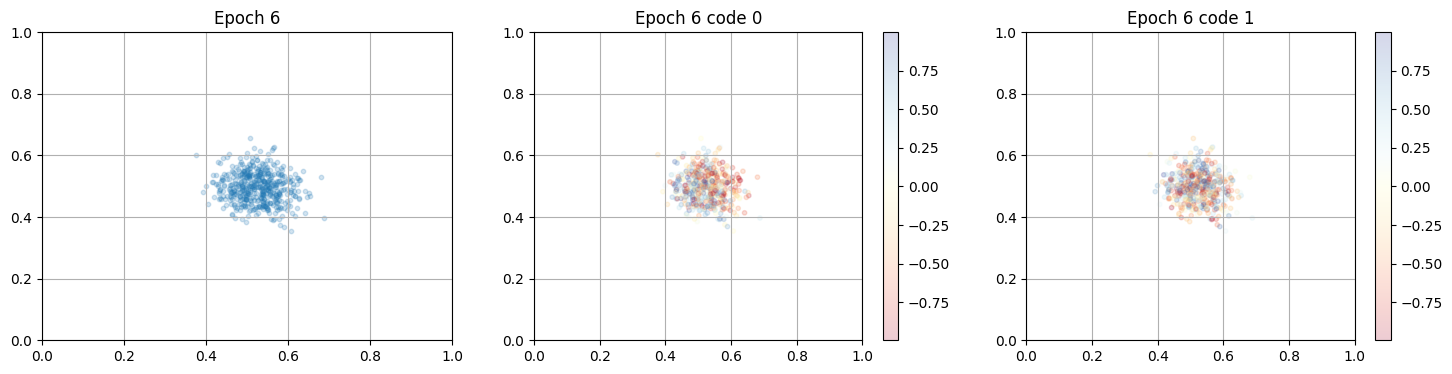

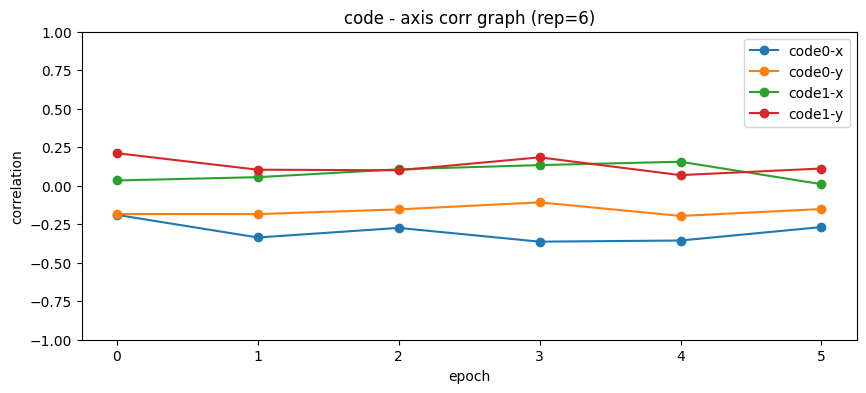

100%|██████████| 31/31 [01:00<00:00,  1.95s/it, G_loss=-.68, D_loss=0.683, MI=-.00125]  


epoch: 7, D_loss: 0.6830452738269683, G_loss: -0.6797989837584957, MI = -0.0012478174701813728
a_loss: -42.14753699302673, b_loss: 36.726304031576625
좌표값 평균 =  0.53049135 0.49658892


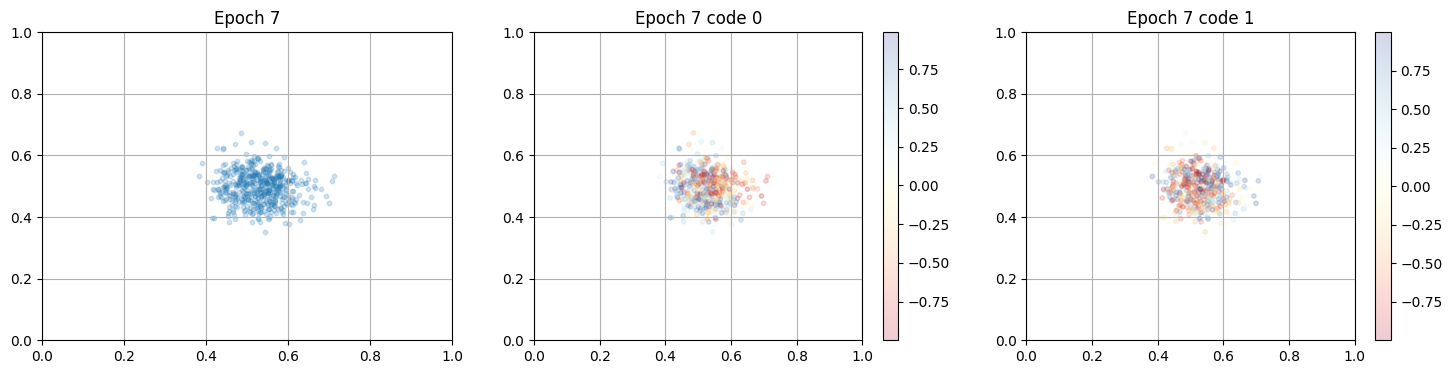

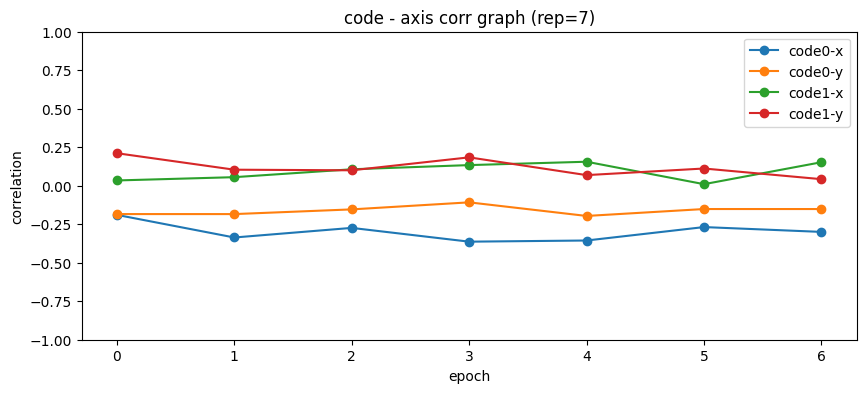

100%|██████████| 31/31 [01:00<00:00,  1.95s/it, G_loss=-.674, D_loss=0.679, MI=0.000361]


epoch: 8, D_loss: 0.678608113719571, G_loss: -0.6736919341548797, MI = 0.000361102242623606
a_loss: -41.76889991760254, b_loss: 36.69428647217231
좌표값 평균 =  0.5377517 0.50122005


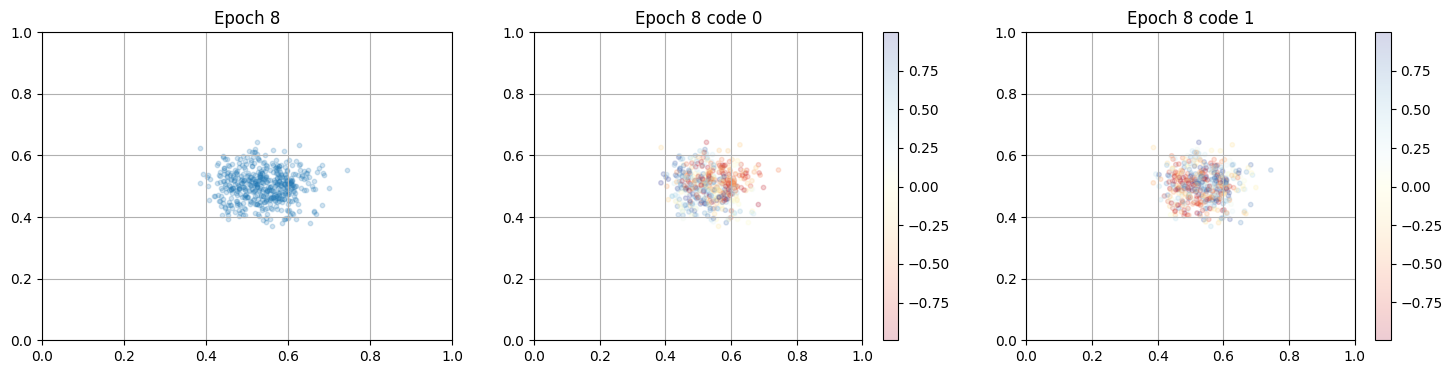

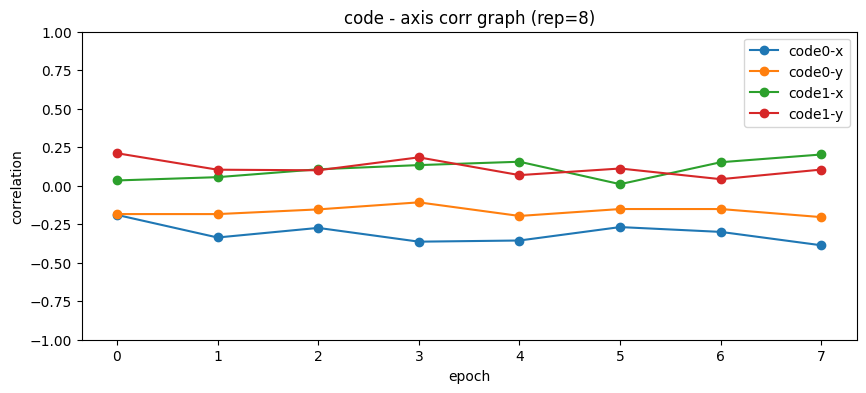

100%|██████████| 31/31 [01:00<00:00,  1.95s/it, G_loss=-.668, D_loss=0.674, MI=0.000468]


epoch: 9, D_loss: 0.6743012955111842, G_loss: -0.6678218360870115, MI = 0.00046763497014199536
a_loss: -41.404953837394714, b_loss: 35.336096691184736
좌표값 평균 =  0.5282914 0.5071647


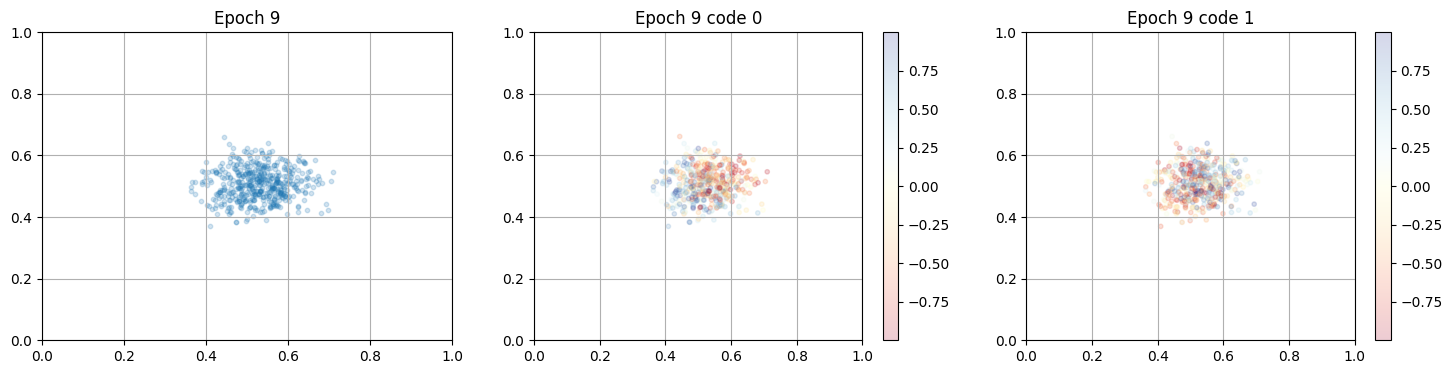

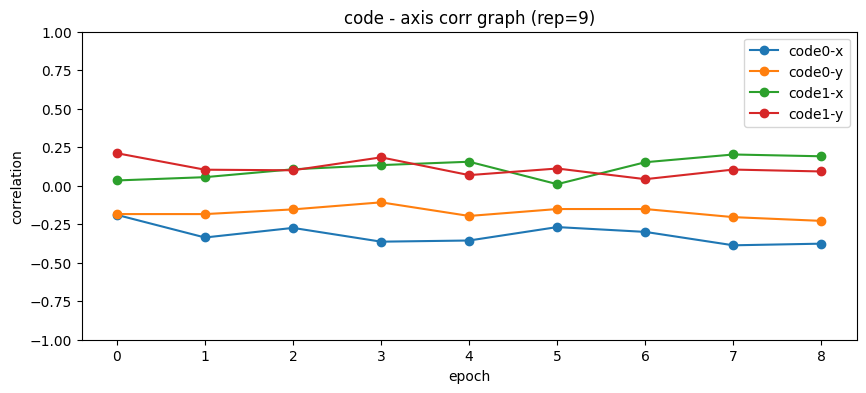

100%|██████████| 31/31 [00:59<00:00,  1.90s/it, G_loss=-.663, D_loss=0.668, MI=0.00238]


epoch: 10, D_loss: 0.6680813489421722, G_loss: -0.6634522484194848, MI = 0.0023834484238778393
a_loss: -41.13403940200806, b_loss: 37.27832214278606
좌표값 평균 =  0.5225628 0.5160345


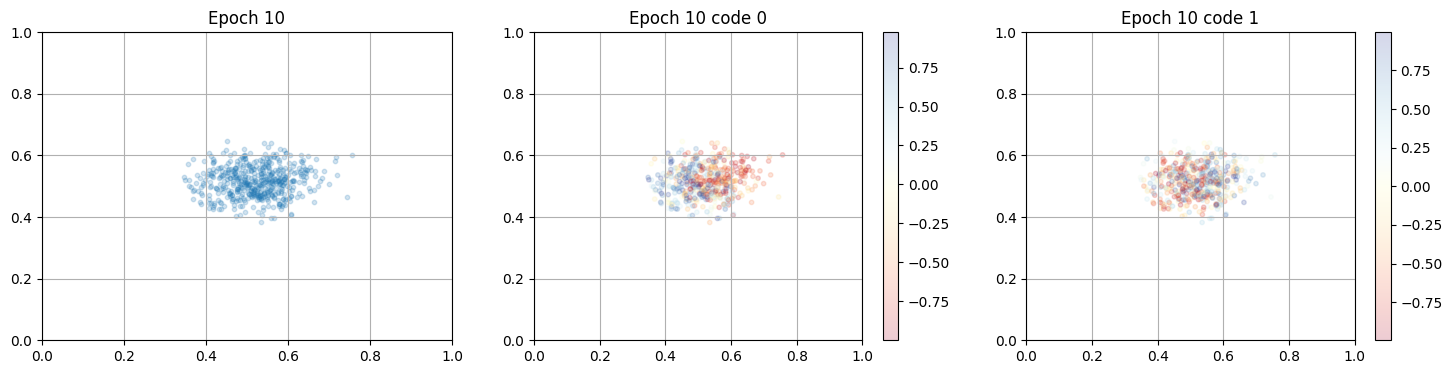

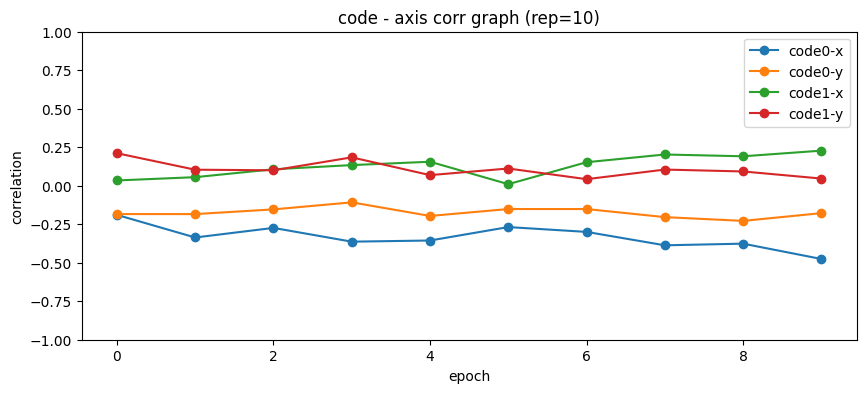

100%|██████████| 31/31 [00:57<00:00,  1.86s/it, G_loss=-.657, D_loss=0.659, MI=0.000583]


epoch: 11, D_loss: 0.6592847916387743, G_loss: -0.657362364953564, MI = 0.0005834246835400981
a_loss: -40.75646662712097, b_loss: 36.447809422998816
좌표값 평균 =  0.500035 0.5199422


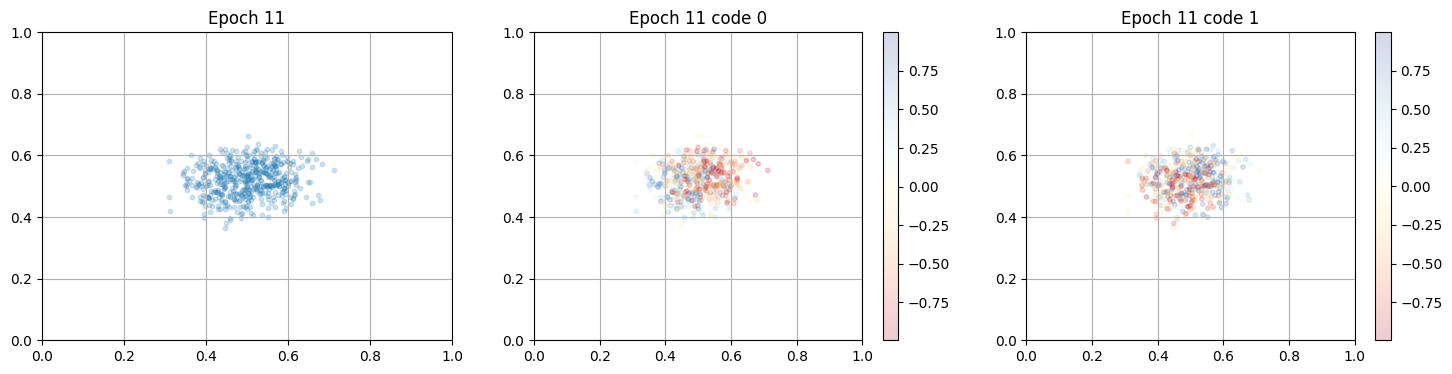

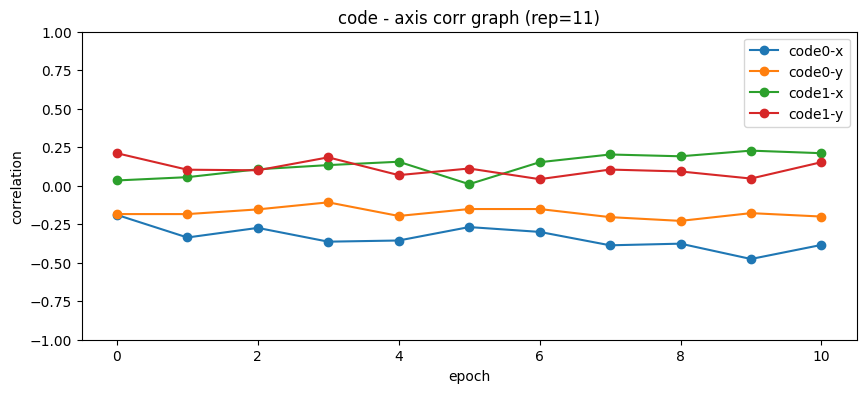

100%|██████████| 31/31 [00:56<00:00,  1.83s/it, G_loss=-.643, D_loss=0.649, MI=0.00183]


epoch: 12, D_loss: 0.6488398813432262, G_loss: -0.6425048670461101, MI = 0.0018346155843427104
a_loss: -39.835301756858826, b_loss: 36.29860899739419
좌표값 평균 =  0.49199823 0.51308835


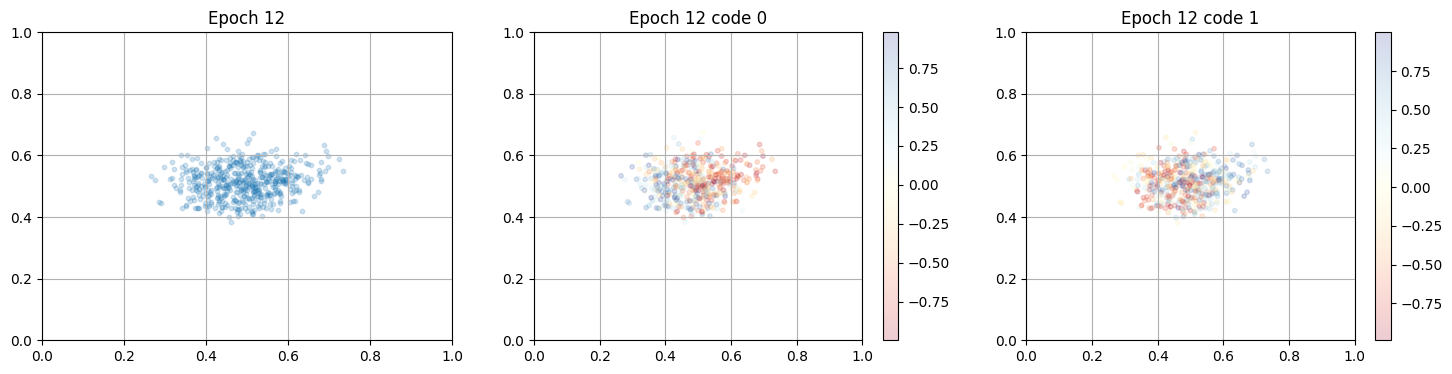

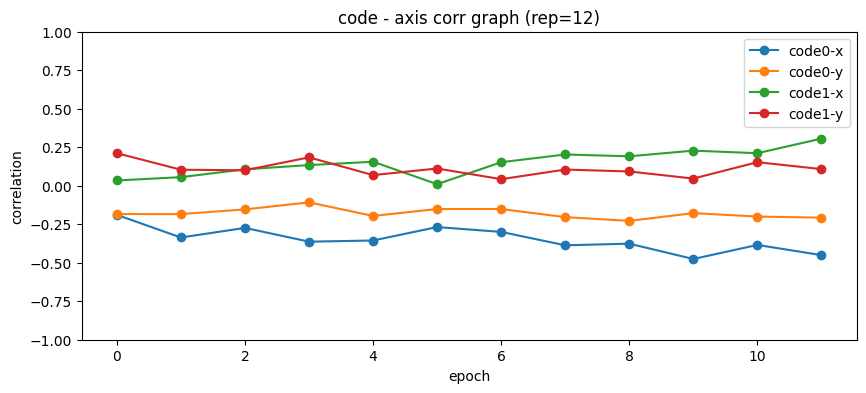

100%|██████████| 31/31 [00:59<00:00,  1.90s/it, G_loss=-.618, D_loss=0.632, MI=0.00359]


epoch: 13, D_loss: 0.6318780587565515, G_loss: -0.6183374447207297, MI = 0.0035937486156340567
a_loss: -38.33692157268524, b_loss: 36.38812403505466
좌표값 평균 =  0.48577714 0.5057765


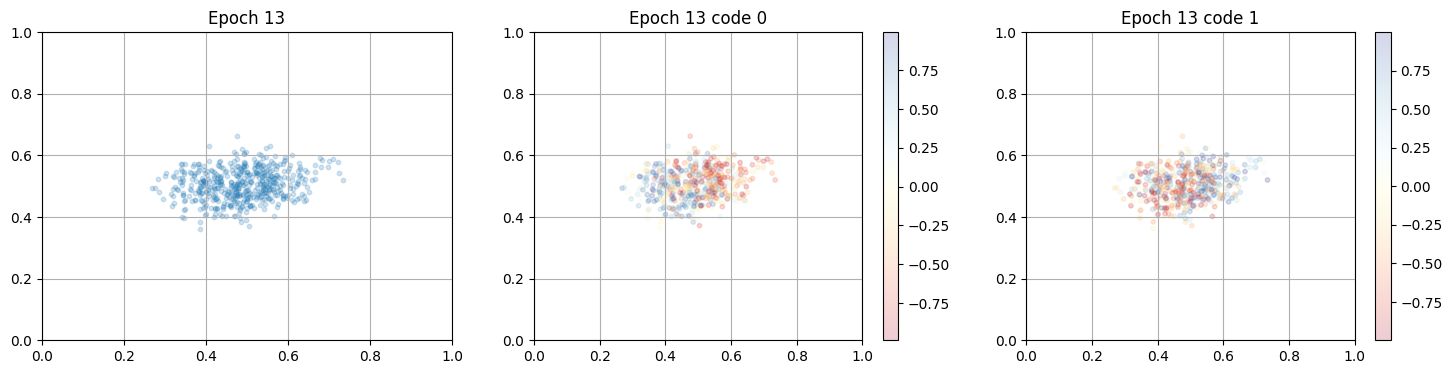

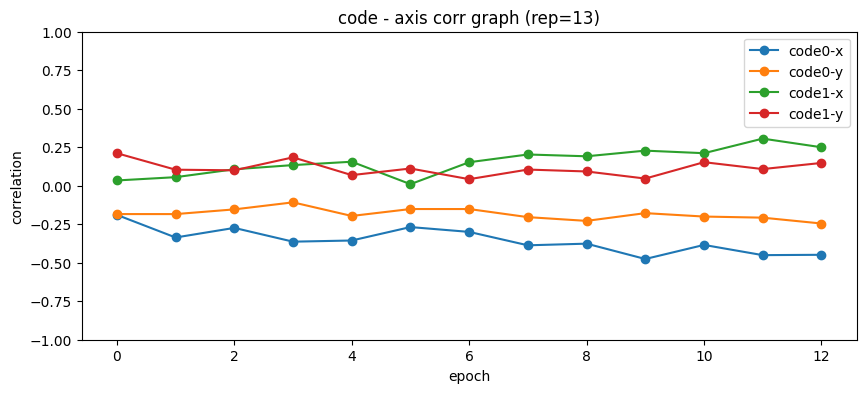

100%|██████████| 31/31 [01:00<00:00,  1.95s/it, G_loss=-.608, D_loss=0.611, MI=0.0028] 


epoch: 14, D_loss: 0.6110366698234312, G_loss: -0.6076985213064379, MI = 0.002795465530887727
a_loss: -37.677308320999146, b_loss: 36.23058603436318
좌표값 평균 =  0.4732279 0.5047843


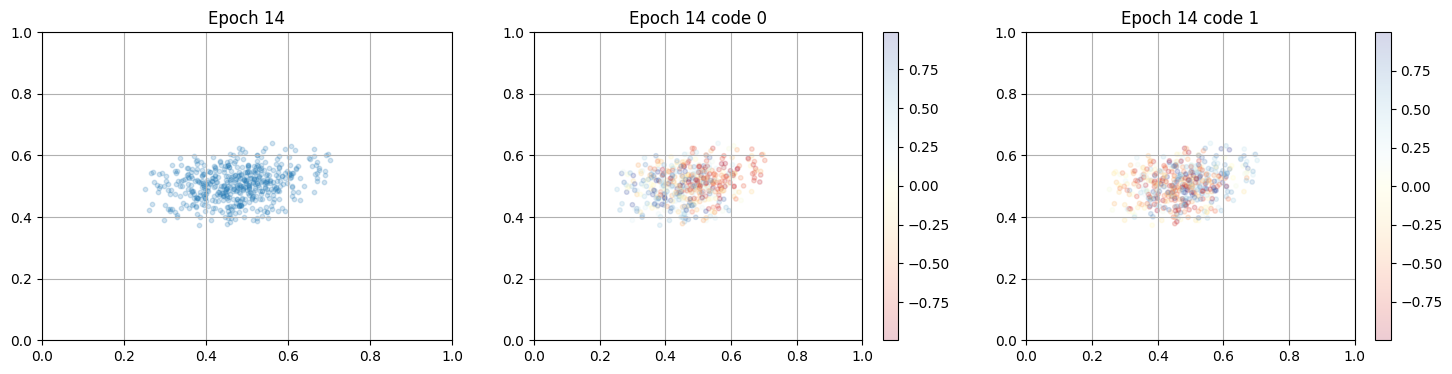

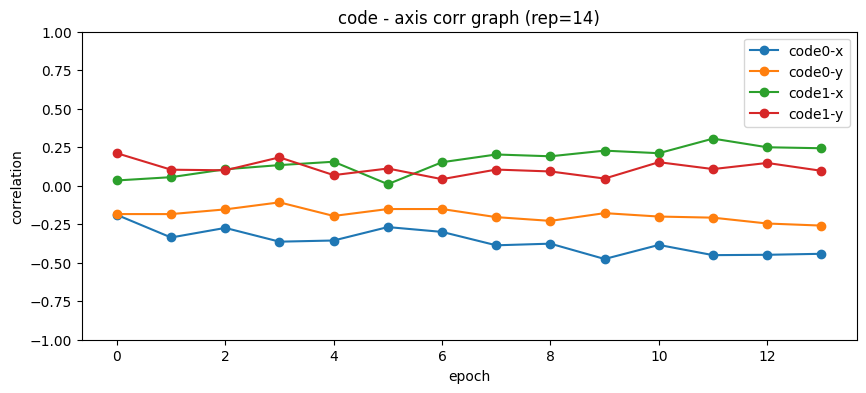

100%|██████████| 31/31 [00:59<00:00,  1.93s/it, G_loss=-.575, D_loss=0.583, MI=0.00527]


epoch: 15, D_loss: 0.5829945379687894, G_loss: -0.5746119618415833, MI = 0.005271768377673241
a_loss: -35.62594163417816, b_loss: 38.42818864315061
좌표값 평균 =  0.4877824 0.4977361


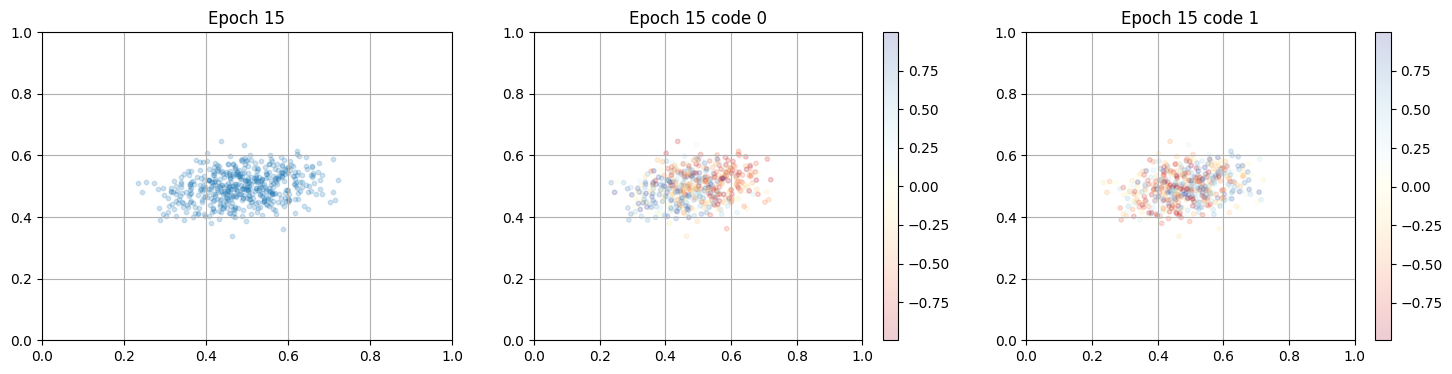

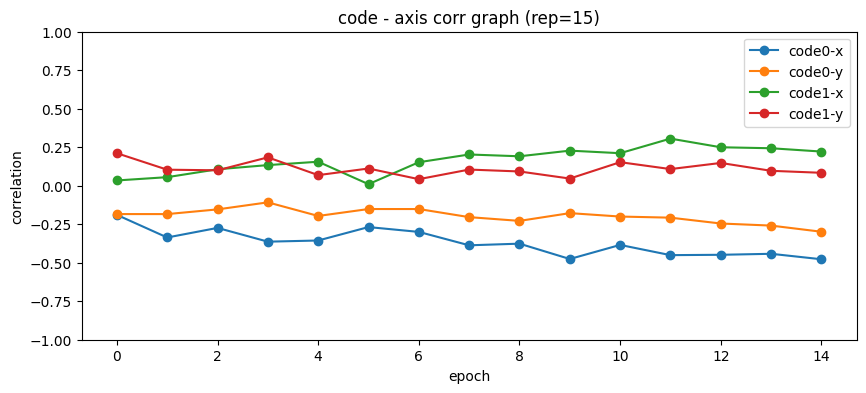

 58%|█████▊    | 18/31 [00:34<00:24,  1.91s/it, G_loss=-.562, D_loss=0.571, MI=0.00426]

In [179]:
import os
epoch = 300
title = 'try22'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')

recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
for i in range(code_qubits):
    recorder_keywords.append(f'code{i}-x')
    recorder_keywords.append(f'code{i}-y')

recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = int(len(x) * 0.5 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    a_loss_sum = 0.0
    b_loss_sum = 0.0
    mi_sum = 0.0
    pbar = tqdm(range(iter_num))
    log_gen_outputs = []
    log_gen_codes = []
    
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss, a, b = generator_train_step(generator_params, generator_seed, use_mine=False, _qmine=False)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input, smoothing=False)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()


        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.
        a_loss_sum += a.item()
        b_loss_sum += b.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_outputs.append(fake_input.numpy())
        log_gen_codes.append(code_input.numpy())

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['a_loss'].append(a_loss_sum/iter_num)
    recorder['b_loss'].append(b_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_outputs = np.concatenate(log_gen_outputs, axis=0)
    log_gen_codes = np.concatenate(log_gen_codes, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))
    print("좌표값 평균 = ", np.mean(log_gen_outputs[:,0]), np.mean(log_gen_outputs[:,1]))

    df = pd.DataFrame({'x': log_gen_outputs[:, 0], 'y': log_gen_outputs[:, 1]})
    for i in range(code_qubits):
        df[f'code{i}']=log_gen_codes[:, i]
    corr_mat = df.corr().to_numpy()
    for i in range(code_qubits):
        recorder[f'code{i}-x'].append(corr_mat[0, i+2])
        recorder[f'code{i}-y'].append(corr_mat[1, i+2])
    
    visualize_output(log_gen_outputs, log_gen_codes, title, rep, recorder)
    final_rep = rep

## 모든 지표 엑셀파일로 저장

In [ ]:
df = pd.DataFrame(recorder)
output_filename = f'result/{title}/recorder.xlsx'
df.to_excel(output_filename, index=False)

## 결과 plot하는 코드

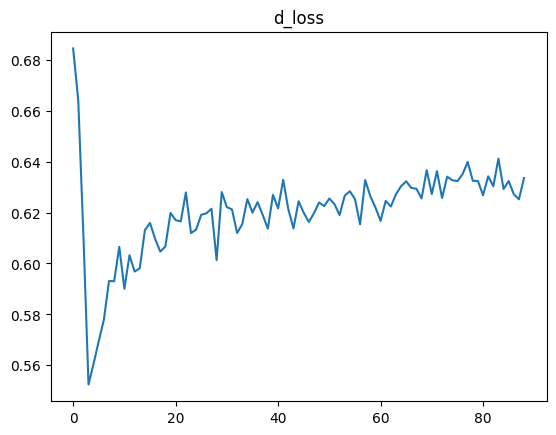

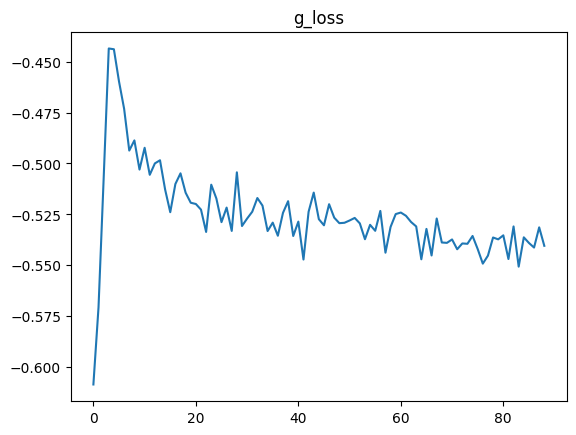

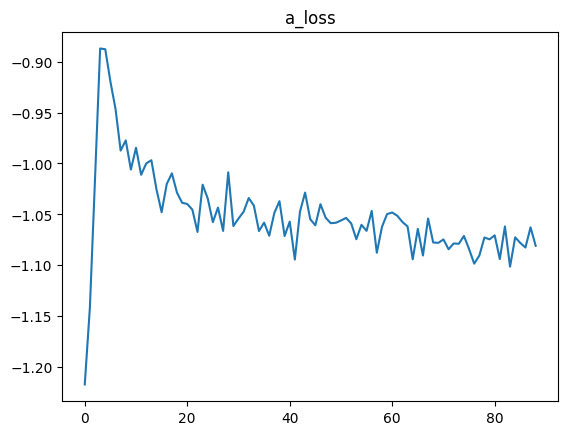

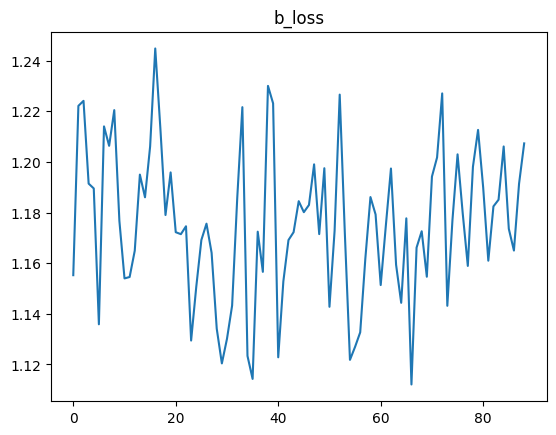

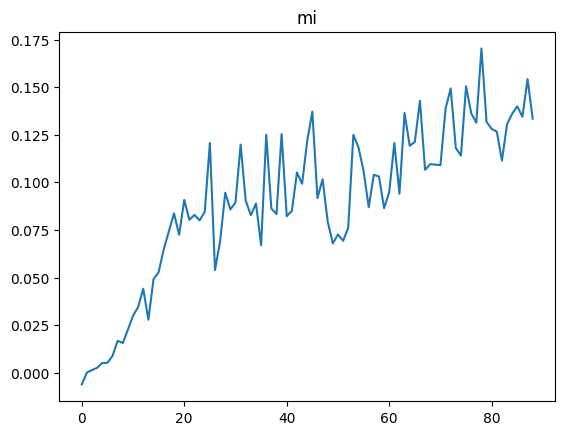

In [ ]:
import matplotlib.pyplot as plt
plot_list = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
for key in plot_list:
    plt.figure()
    plt.title(key)
    plt.plot(recorder[key])
    plt.savefig(f'result/{title}/{key}.png')
    plt.show()


In [64]:
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('coeff = {}\n'.format(coeff))

## 모델 저장 스크립트

In [65]:
with open(f'result/{title}/discriminator.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator.pkl', 'wb') as file:
    pickle.dump(generator_params, file)

100%|██████████| 5000/5000 [04:43<00:00, 17.62it/s]


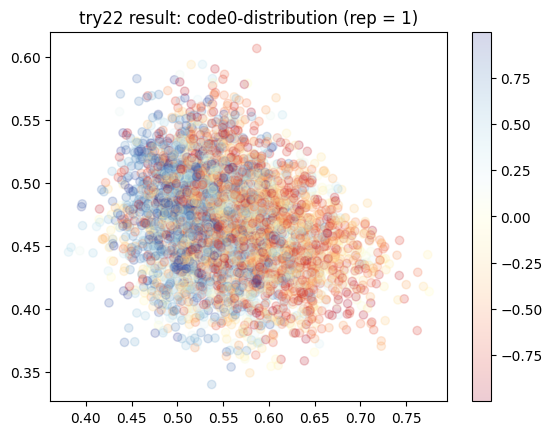

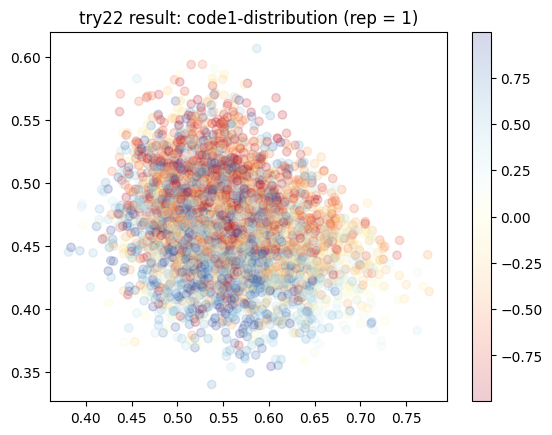

In [121]:
inputs = []
outputs = []

for i in tqdm(range(5000)):
    with torch.no_grad():
        z = np.random.uniform(-1, 1, (1, n_qubits, 1))
        code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
        generator_output, _ = generator_forward(generator_params, z)
        generator_output = generator_output.cpu().numpy().reshape(output_qubits)
        outputs.append(generator_output)
        inputs.append(code_input)

inputs = np.array(inputs).reshape(-1, code_qubits)

for code_ind in range(code_qubits):
    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs[:, code_ind], cmap='RdYlBu', alpha=0.2)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'{title} result: code{code_ind}-distribution (rep = {final_rep})')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()


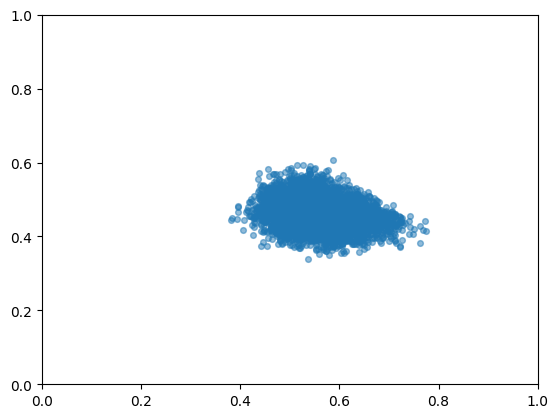

In [122]:
outputs = np.array(outputs)
plt.scatter(outputs[:, 0], outputs[:, 1], s=17, alpha=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [124]:
import pandas as pd
df = pd.DataFrame({'x': outputs[:, 0], 'y': outputs[:, 1]})
for i in range(code_qubits):
    df[f'code{i}']=inputs[:, i]
corr_mat = df.corr()

In [131]:
print(corr_mat.to_numpy()[-2:, :2])

[[-0.33369657  0.05014263]
 [-0.04456902 -0.27143691]]


In [132]:
corr_mat

,x,y,code0,code1
x,1.000000,-0.259401,-0.333697,-0.044569
y,-0.259401,1.000000,0.050143,-0.271437
code0,-0.333697,0.050143,1.000000,-0.004996
code1,-0.044569,-0.271437,-0.004996,1.000000


## 모델 불러오는 스크립트

title변수가 디렉토리를 지정합니다.

In [40]:
import pickle

with open(f'result/{title}/discriminator2.pkl', 'rb') as file:
    discriminator = pickle.load(file)

with open(f'result/{title}/generator.pkl', 'rb') as file:
    generator_params = pickle.load(file)

In [21]:
title = 'try14'

In [39]:
with open(f'result/{title}/discriminator2.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator2.pkl', 'wb') as file:
    pickle.dump(generator_params, file)

/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/pennylane/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from curr

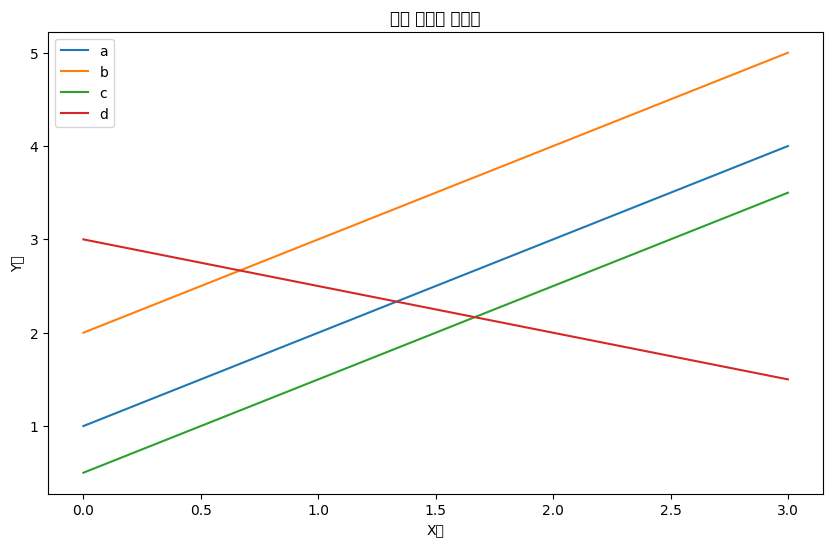

In [134]:
import matplotlib.pyplot as plt

# 예시 데이터
data = {
    'a': [1.0, 2.0, 3.0, 4.0],
    'b': [2.0, 3.0, 4.0, 5.0],
    'c': [0.5, 1.5, 2.5, 3.5],
    'd': [3.0, 2.5, 2.0, 1.5]
}

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# 각 데이터를 동시에 그래프로 표시
for key, value in data.items():
    plt.plot(value, label=key)

# 레이블과 범례 추가
plt.xlabel('X축')
plt.ylabel('Y축')
plt.title('다중 데이터 그래프')
plt.legend()

# 그래프 표시
plt.show()
